In [2]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib_venn import venn2

import json

import config
config.config_visuals()

# Load peaks

In [3]:
peak_anno = pd.read_csv("../data/raw/peak_anno.csv", index_col=0)
annotations_edb = pd.read_csv("../data/raw/peak_gene_ids.csv", index_col=0)

entrez_to_ensembl = dict(zip(annotations_edb["ENTREZID"], annotations_edb["GENEID"]))
entrez_to_name = dict(zip(annotations_edb["ENTREZID"], annotations_edb["GENENAME"]))

peak_anno["ensembl_gene"] = peak_anno["geneId"].apply(entrez_to_ensembl.get)
peak_anno["gene_name"] = peak_anno["geneId"].apply(entrez_to_name.get)

peak_ensembl_genes = set(peak_anno["ensembl_gene"])

# Load experiments

In [4]:
with open("experiments.json", "r") as f:
    exp = json.load(f)

    experiments = exp["experiments"]
    experiment_ids = exp["experiment_ids"]
    display_names = exp["display_names"]
    display_groups = exp["display_groups"]
    contexts = exp["contexts"]

In [5]:
kallisto_sleuth_path = "../data/processed/kallisto_sleuth_merge/"

rpl22_oe_genes = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_oe_genes.h5", key="sleuth_diff"
)
rpl22l1_oe_genes = pd.read_hdf(
    kallisto_sleuth_path + "rpl22l1_oe_genes.h5", key="sleuth_diff"
)
rpl22l1_kd1_genes = pd.read_hdf(
    kallisto_sleuth_path + "rpl22l1_kd1_genes.h5", key="sleuth_diff"
)
rpl22l1_kd2_genes = pd.read_hdf(
    kallisto_sleuth_path + "rpl22l1_kd2_genes.h5", key="sleuth_diff"
)
rpl22_a_ko1_genes = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_a_ko1_genes.h5", key="sleuth_diff"
)
rpl22_a_ko2_genes = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_a_ko2_genes.h5", key="sleuth_diff"
)
rpl22_b_ko1_genes = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_b_ko1_genes.h5", key="sleuth_diff"
)
rpl22_b_ko2_genes = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_b_ko2_genes.h5", key="sleuth_diff"
)

rpl22_oe_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22_oe.h5", key="rmats")
rpl22l1_oe_rmats = pd.read_hdf(
    "../data/processed/rmats_merge/rpl22l1_oe.h5", key="rmats"
)
rpl22l1_kd1_rmats = pd.read_hdf(
    "../data/processed/rmats_merge/rpl22l1_kd1.h5", key="rmats"
)
rpl22l1_kd2_rmats = pd.read_hdf(
    "../data/processed/rmats_merge/rpl22l1_kd2.h5", key="rmats"
)
rpl22_a_ko1_rmats = pd.read_hdf(
    "../data/processed/rmats_merge/rpl22_a_ko1.h5", key="rmats"
)
rpl22_a_ko2_rmats = pd.read_hdf(
    "../data/processed/rmats_merge/rpl22_a_ko2.h5", key="rmats"
)
rpl22_b_ko1_rmats = pd.read_hdf(
    "../data/processed/rmats_merge/rpl22_b_ko1.h5", key="rmats"
)
rpl22_b_ko2_rmats = pd.read_hdf(
    "../data/processed/rmats_merge/rpl22_b_ko2.h5", key="rmats"
)

In [6]:
def combine(df1, df2, sort_col):
    # combine two dataframes, take max pval for intersection analysis

    combined = pd.concat([df1, df2])
    combined = combined.sort_values(by=sort_col)

    combined = combined[combined.index.value_counts() == 2]

    combined = combined[~combined.index.duplicated(keep="last")]

    return combined

rpl22l1_kd_genes = combine(rpl22l1_kd1_genes, rpl22l1_kd2_genes, "qval")
rpl22_a_ko_genes = combine(rpl22_a_ko1_genes, rpl22_a_ko2_genes, "qval")
rpl22_b_ko_genes = combine(rpl22_b_ko1_genes, rpl22_b_ko2_genes, "qval")

rpl22l1_kd_rmats = combine(rpl22l1_kd1_rmats, rpl22l1_kd2_rmats, "FDR")
rpl22_a_ko_rmats = combine(rpl22_a_ko1_rmats, rpl22_a_ko2_rmats, "FDR")
rpl22_b_ko_rmats = combine(rpl22_b_ko1_rmats, rpl22_b_ko2_rmats, "FDR")

/var/folders/c8/rk9y5xz57x5_t_g3v746g7lm0000gn/T/ipykernel_97021/32438674.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  combined = combined[combined.index.value_counts() == 2]
/var/folders/c8/rk9y5xz57x5_t_g3v746g7lm0000gn/T/ipykernel_97021/32438674.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  combined = combined[combined.index.value_counts() == 2]
/var/folders/c8/rk9y5xz57x5_t_g3v746g7lm0000gn/T/ipykernel_97021/32438674.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  combined = combined[combined.index.value_counts() == 2]
/var/folders/c8/rk9y5xz57x5_t_g3v746g7lm0000gn/T/ipykernel_97021/32438674.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  combined = combined[combined.index.value_counts() == 2]
/var/folders/c8/rk9y5xz57x5_t_g3v746g7lm0000gn/T/ipykernel_97021/32438674.py:7: UserWarning: Boolean Series key will be reindexed to match DataF

# Expression vs. peaks

In [7]:
def expression_peaks_overlap(genes, cutoff, title, show_labels=False, ax=None):

    if ax is None:
        fig = plt.figure(figsize=(4, 3))
        ax = plt.subplot(111)

    genes_significant = genes[genes["qval"] < cutoff]

    expression_ids = set(genes_significant.index)

    len_both = len(peak_ensembl_genes & expression_ids)

    if show_labels:
        set_labels = ("Genes with peaks", "Δ spliced genes")
    else:
        set_labels = ["", ""]

    v = venn2(
        subsets={
            "10": len(peak_ensembl_genes) - len_both,
            "01": len(expression_ids) - len_both,
            "11": len_both,
        },
        set_labels=set_labels,
        ax=ax,
    )

    for patch_id, color in zip(["10", "11", "01"], ["#4ecca3", "white", "#6eb6ff"]):

        v.get_patch_by_id(patch_id).set_alpha(1.0)
        v.get_patch_by_id(patch_id).set_color(color)
        v.get_patch_by_id(patch_id).set_lw(1)
        v.get_patch_by_id(patch_id).set_ls("solid")
        v.get_patch_by_id(patch_id).set_edgecolor("black")
        
    ax.set_title(title)
    

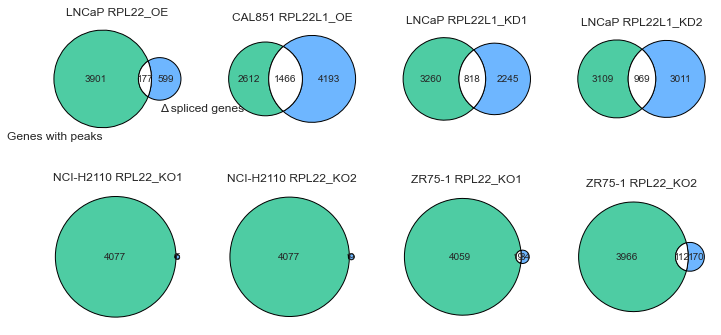

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

expression_peaks_overlap(
    rpl22_oe_genes, title="LNCaP RPL22_OE", show_labels=True, cutoff=0.01, ax=axes[0][0]
)
expression_peaks_overlap(
    rpl22l1_oe_genes, title="CAL851 RPL22L1_OE", cutoff=0.01, ax=axes[0][1]
)
expression_peaks_overlap(
    rpl22l1_kd1_genes, title="LNCaP RPL22L1_KD1", cutoff=0.01, ax=axes[0][2]
)
expression_peaks_overlap(
    rpl22l1_kd2_genes, title="LNCaP RPL22L1_KD2", cutoff=0.01, ax=axes[0][3]
)
expression_peaks_overlap(
    rpl22_a_ko1_genes, title="NCI-H2110 RPL22_KO1", cutoff=0.01, ax=axes[1][0]
)
expression_peaks_overlap(
    rpl22_a_ko2_genes, title="NCI-H2110 RPL22_KO2", cutoff=0.01, ax=axes[1][1]
)
expression_peaks_overlap(
    rpl22_b_ko1_genes, title="ZR75-1 RPL22_KO1", cutoff=0.01, ax=axes[1][2]
)
expression_peaks_overlap(
    rpl22_b_ko2_genes, title="ZR75-1 RPL22_KO2", cutoff=0.01, ax=axes[1][3]
)

plt.savefig(
    "../plots/expression_peak_intersections.pdf", transparent=True, bbox_inches="tight"
)

# Splicing vs. peaks

In [20]:
def splicing_peaks_overlap(rmats, cutoff, title, show_labels=False, ax=None):

    if ax is None:
        fig = plt.figure(figsize=(4, 3))
        ax = plt.subplot(111)

    rmats_significant = rmats[rmats["FDR"] < cutoff]

    rmats_ids = set(rmats_significant["GeneID"])

    len_both = len(peak_ensembl_genes & rmats_ids)

    if show_labels:
        set_labels = ("Genes with peaks", "Δ spliced genes")
    else:
        set_labels = ["", ""]

    v = venn2(
        subsets={
            "10": len(peak_ensembl_genes) - len_both,
            "01": len(rmats_ids) - len_both,
            "11": len_both,
        },
        set_labels=set_labels,
        ax=ax,
    )

    for patch_id, color in zip(["10", "11", "01"], ["#4ecca3", "white", "#6eb6ff"]):

        v.get_patch_by_id(patch_id).set_alpha(1.0)
        v.get_patch_by_id(patch_id).set_color(color)
        v.get_patch_by_id(patch_id).set_lw(1)
        v.get_patch_by_id(patch_id).set_ls("solid")
        v.get_patch_by_id(patch_id).set_edgecolor("black")
        
    ax.set_title(title)
    
    return peak_ensembl_genes & rmats_ids
    

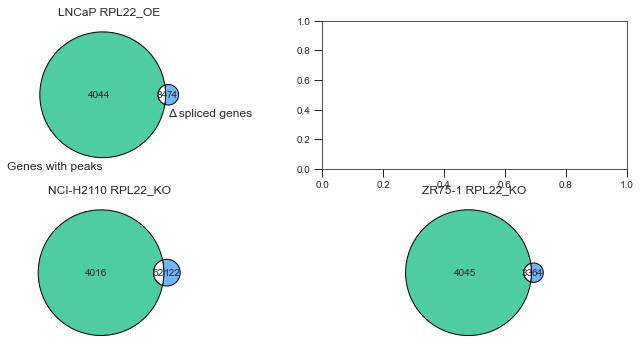

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

splicing_peaks_overlap(
    rpl22_oe_rmats, title="LNCaP RPL22_OE", show_labels=True, cutoff=0.01, ax=axes[0][0]
)
# splicing_peaks_overlap(
#     rpl22l1_oe_rmats, title="CAL851 RPL22L1_OE", cutoff=0.01, ax=axes[0][1]
# )
# splicing_peaks_overlap(
#     rpl22l1_kd_rmats, title="LNCaP RPL22L1_KD", cutoff=0.01, ax=axes[0][2]
# )
splicing_peaks_overlap(
    rpl22_a_ko_rmats, title="NCI-H2110 RPL22_KO", cutoff=0.01, ax=axes[1][0]
)
splicing_peaks_overlap(
    rpl22_b_ko_rmats, title="ZR75-1 RPL22_KO", cutoff=0.01, ax=axes[1][1]
)

plt.savefig(
    "../plots/fig4_splicing_peak_intersections.pdf", transparent=True, bbox_inches="tight"
)